In [1]:
import os
from shutil import copyfile
import yaml

import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import CubicSpline

[[0.0, 0.0], [0.04894348370484647, 0.3090169943749474], [0.26468816542991247, 0.6208232223238989], [0.5019885800493985, 1.0998487522256688], [0.8450032970292549, 1.2380797169672486], [1.2160620255245633, 1.0751998073058586], [1.5253663318453599, 1.0265757438845495], [1.5902920966448222, 0.9859690212220955], [1.988377093709754, 0.6109143779696932], [1.9922361069047212, 0.3244956328815299], [2.2901672852542525, 0.08515119979459561], [2.01340372579586, -0.4712882765562675], [1.8449043510150425, -0.7001632023983063], [1.850522299553958, -0.8399988040486873], [1.3954494406225195, -1.2343380725777582], [1.2869281019344152, -1.1881767962379404], [0.8454057130918371, -1.1996480986234983], [0.5647378293314572, -0.8938774470463045], [0.19098300562505266, -0.5877852522924734], [0.04894348370484647, -0.3090169943749476]]


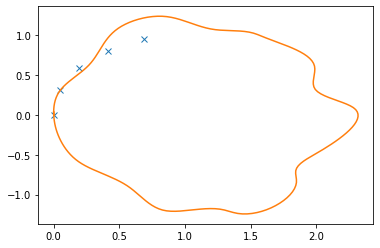

In [25]:
output_path = os.environ['DATADIR'] + '/create_line_world'
os.makedirs(output_path, exist_ok=True)
number_of_points = 20
dev = 0.3

# start from loop
t = np.arange(0, 1., 1/number_of_points)
xo = -np.cos(2*np.pi*t) + 1
yo = np.sin(2*np.pi*t)

# deviate points with noise
x = [exo + np.sign(exo) * np.random.uniform(0, dev) * (i!=0 and i != 1 and i!=(len(xo)-1) and i!=(len(xo)-2)) for i, exo in enumerate(xo)]
y = [eyo + np.sign(eyo) * np.random.uniform(0, dev) * (i!=0 and i != 1 and i!=(len(yo)-1) and i!=(len(yo)-2)) for i, eyo in enumerate(yo)]
x += [x[0]]
y += [y[0]]
waypoints = [[x[i], y[i]] for i in range(len(x)-1)]
print(waypoints)

plt.figure()
plt.plot(xo[:5], yo[:5], 'x')

tck, u = interpolate.splprep([x, y], s=0, k=3, per=True)
unew = np.arange(0, 1.01, 1/(10*number_of_points))
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])#, np.sin(2*np.pi*unew), np.cos(2*np.pi*unew), x, y, 'b')
plt.show()



In [3]:
# Use interpolated points to connect tiny cylinders in gazebo

r = 0.01
l = 0.06

# Load empty world:
world_dir = 'src/sim/ros/gazebo/worlds'
tree = ET.parse(os.path.join(os.environ['PWD'], world_dir, 'empty.world'))
root = tree.getroot()
world = root.find('world')

# add model to world
model = ET.SubElement(world, 'model', attrib={'name': 'line'})

# Place small cylinders in one model
x_coords, y_coords = out
for index, (x, y) in enumerate(zip(x_coords, y_coords)):
    link=ET.SubElement(model, 'link', attrib={'name':f'link_{index}'})
    pose = ET.SubElement(link, 'pose', attrib={'frame':''})
    
    next_x = x_coords[(index + 1) % len(x_coords)]
    next_y = y_coords[(index + 1) % len(x_coords)]
    derivative = (next_y - y)/(next_x - x)
    slope = np.arctan(derivative)
    pose.text = f'{x} {y} {r} 0 1.57 {slope}'
    collision = ET.SubElement(link, 'collision', attrib={'name':'collision'})
    visual = ET.SubElement(link, 'visual', attrib={'name':'visual'})
    material = ET.SubElement(visual,'material')
    script = ET.SubElement(material,'script')
    name = ET.SubElement(script,'name')
    name.text='Gazebo/Blue'
    uri = ET.SubElement(script,'uri')
    uri.text='file://media/materials/scripts/gazebo.material'
    for element in [collision,visual]: 
        geo = ET.SubElement(element, 'geometry')
        cylinder = ET.SubElement(geo, 'cylinder')
        radius = ET.SubElement(cylinder, 'radius')
        radius.text=str(r)
        length = ET.SubElement(cylinder, 'length')
        length.text=str(l)

# Store world
model_name = f'model_{sum(x_coords)}'
world_dir = 'src/sim/ros/gazebo/worlds'
os.makedirs(os.path.join(os.environ['PWD'], world_dir, 'line_worlds'), exist_ok=True)
tree.write(os.path.join(os.environ['PWD'], world_dir, 'line_worlds', model_name + '.world'), encoding="us-ascii", xml_declaration=True, method="xml")


In [11]:
# Create world config with waypoints
world_config_dir = 'src/sim/ros/config/world'
config = {
    'world_name': model_name,
    'max_duration': 300,
    'starting_height': 0.5,
    'delay_evaluation': 1,
    'waypoints': [[float(w[0]), float(w[1])] for w in waypoints],
    'waypoint_reached_distance': 0.2,
    'goal': {
        'x': {'min': float(waypoints[-1][0]) - 0.3,
              'max': float(waypoints[-1][0]) + 0.3},
        'y': {'min': float(waypoints[-1][1]) - 0.3,
              'max': float(waypoints[-1][1]) + 0.3},
        'z': {'min': 0.3,
              'max': 0.8},
    }
}

os.makedirs(os.path.join(os.environ['PWD'], world_config_dir, 'line_worlds'), exist_ok=True)
with open(os.path.join(os.environ['PWD'], world_config_dir, 'line_worlds', model_name + '.yml'), 'w') as f:
    yaml.dump(config, f)


In [9]:
waypoints

[[0.0, 0.0],
 [0.04894348370484647, 0.3090169943749474],
 [0.46315340962163504, 0.7650786822120781],
 [0.6431455415921046, 0.976386707786975],
 [0.8239877157749642, 1.1921047920961372],
 [1.2078682587154994, 1.2859714873399017],
 [1.557243528490979, 0.9966184048650034],
 [1.7128811922183076, 0.844032238043152],
 [1.834588247481981, 0.6890159160380466],
 [1.9865754154978674, 0.5141618686417417],
 [2.209453276332262, 0.025847543518018577],
 [2.0499125003951293, -0.3753169330883018],
 [1.9246745493127149, -0.6703745656275261],
 [1.790918868316677, -0.8220244976363261],
 [1.3507281729696856, -1.041181807643188],
 [1.2945190648688354, -1.0744896412610545],
 [0.7769019361668801, -0.985952357955942],
 [0.466280923433653, -1.0967159184547013],
 [0.19098300562505266, -0.5877852522924734],
 [0.04894348370484647, -0.3090169943749476]]